In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Folds.csv
/kaggle/input/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/README.txt
/kaggle/input/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/count_files.sh
/kaggle/input/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/process_db_stat.py
/kaggle/input/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/fibroadenoma.stat.txt
/kaggle/input/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/phyllodes_tumor.stat.txt
/kaggle/input/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/tubular_adenoma.stat.txt
/kaggle/input/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/adenosis.stat.txt
/kaggle/input/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/README_B.txt
/kaggle/input/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-012.png
/kaggle/input/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-009.png
/kaggle/input/Br

In [2]:
#Step1: Import libraries
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.metrics import AUC, Precision, Recall, TruePositives, TrueNegatives

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print("All libraries imported and seeds set successfully.")


2025-07-23 12:13:26.482422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753272806.822296    1601 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753272806.921394    1601 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported and seeds set successfully.


Sample path parts: ['', 'kaggle', 'input', 'BreaKHis_v1', 'BreaKHis_v1', 'histology_slides', 'breast', 'benign', 'SOB', 'adenosis', 'SOB_B_A_14-29960CD', '200X', 'SOB_B_A-14-29960CD-200-012.png']
Sample path parts: ['', 'kaggle', 'input', 'BreaKHis_v1', 'BreaKHis_v1', 'histology_slides', 'breast', 'benign', 'SOB', 'adenosis', 'SOB_B_A_14-29960CD', '200X', 'SOB_B_A-14-29960CD-200-009.png']
Sample path parts: ['', 'kaggle', 'input', 'BreaKHis_v1', 'BreaKHis_v1', 'histology_slides', 'breast', 'benign', 'SOB', 'adenosis', 'SOB_B_A_14-29960CD', '200X', 'SOB_B_A-14-29960CD-200-006.png']
Sample path parts: ['', 'kaggle', 'input', 'BreaKHis_v1', 'BreaKHis_v1', 'histology_slides', 'breast', 'benign', 'SOB', 'adenosis', 'SOB_B_A_14-29960CD', '200X', 'SOB_B_A-14-29960CD-200-011.png']
Sample path parts: ['', 'kaggle', 'input', 'BreaKHis_v1', 'BreaKHis_v1', 'histology_slides', 'breast', 'benign', 'SOB', 'adenosis', 'SOB_B_A_14-29960CD', '200X', 'SOB_B_A-14-29960CD-200-004.png']
Total image files fo

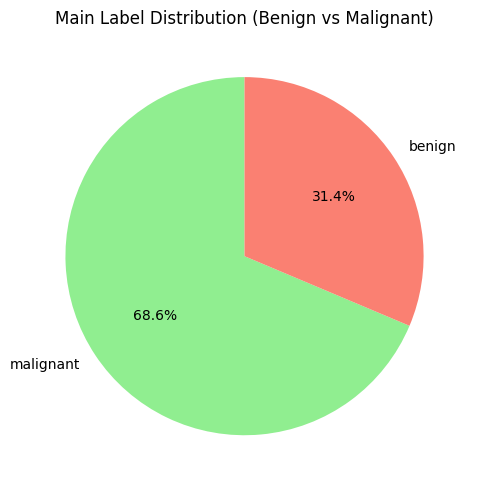

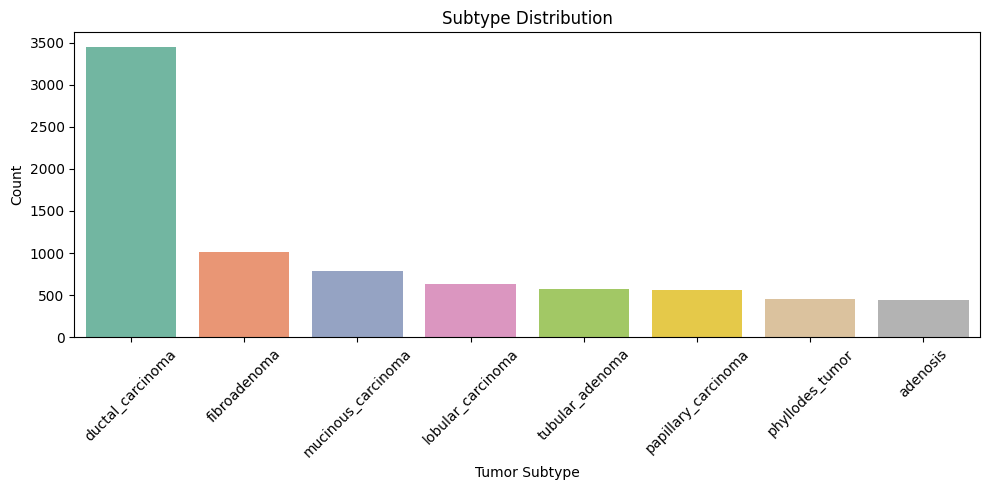

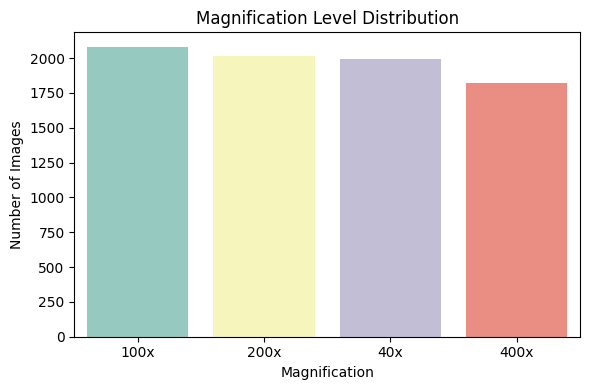

In [3]:
# Step 2: Load Metadata

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = '/kaggle/input/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
IMAGE_EXTENSIONS = ('.png', '.jpg', '.jpeg')

def extract_metadata(image_root):
    data = []
    count_files = 0
    for root, _, files in os.walk(image_root):
        for file in files:
            if file.lower().endswith(IMAGE_EXTENSIONS):
                count_files += 1
                path = os.path.join(root, file)
                parts = path.split(os.sep)
                # Print first few paths for inspection
                if count_files <= 5:
                    print("Sample path parts:", parts)
                try:
                    idx = parts.index('breast')
                    label_type = parts[idx + 1].lower()
                    subtype = parts[idx + 3].lower()  # tumor subtype folder
                    magnification = parts[-2].lower()
                    data.append({
                        'image_path': path,
                        'file_name': file,
                        'label': 0 if label_type == 'benign' else 1,
                        'main_label': label_type,
                        'subtype': subtype,
                        'magnification': magnification
                    })
                except (ValueError, IndexError):
                    continue
    print(f"Total image files found: {count_files}")
    print(f"Metadata entries extracted: {len(data)}")
    return pd.DataFrame(data)

df = extract_metadata(DATA_DIR)

if 'main_label' in df.columns:
    df = df.sort_values('main_label').reset_index(drop=True)
    print(f"Metadata loaded successfully with {len(df)} entries.")
    print(df.head())
else:
    print("No valid metadata entries found, DataFrame columns:", df.columns)

print(df['main_label'].value_counts())
print(df['subtype'].value_counts())
print(df['magnification'].value_counts())

# === Visualization ===

# 1. Pie chart for benign vs malignant distribution
plt.figure(figsize=(5, 5))
df['main_label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen', 'salmon'], startangle=90)
plt.title("Main Label Distribution (Benign vs Malignant)")
plt.ylabel('')
plt.tight_layout()
plt.show()

# 2. Bar plot for subtype distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='subtype', data=df, palette='Set2', order=df['subtype'].value_counts().index)
plt.title("Subtype Distribution")
plt.xlabel("Tumor Subtype")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Bar plot for magnification levels
plt.figure(figsize=(6, 4))
sns.countplot(x='magnification', data=df, palette='Set3', order=df['magnification'].value_counts().index)
plt.title("Magnification Level Distribution")
plt.xlabel("Magnification")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


In [4]:
# Step 2A: Minimalist Data Cleaning

# Remove entries with missing or empty image paths
df = df[df['image_path'].notna() & df['image_path'].str.strip().ne('')]

# Remove entries with non-existent image files (optional but useful in some environments)
df = df[df['image_path'].apply(lambda x: os.path.exists(x))]

# Ensure label is 0 or 1 only
df = df[df['label'].isin([0, 1])]

# Sort for consistency and reset index
df = df.sort_values(by='main_label').reset_index(drop=True)

print(f"Data cleaned successfully. Total valid entries: {len(df)}")
print(df[['image_path', 'label', 'main_label', 'subtype', 'magnification']].head())


Data cleaned successfully. Total valid entries: 7909
                                          image_path  label main_label  \
0  /kaggle/input/BreaKHis_v1/BreaKHis_v1/histolog...      0     benign   
1  /kaggle/input/BreaKHis_v1/BreaKHis_v1/histolog...      0     benign   
2  /kaggle/input/BreaKHis_v1/BreaKHis_v1/histolog...      0     benign   
3  /kaggle/input/BreaKHis_v1/BreaKHis_v1/histolog...      0     benign   
4  /kaggle/input/BreaKHis_v1/BreaKHis_v1/histolog...      0     benign   

    subtype magnification  
0  adenosis          200x  
1  adenosis          200x  
2  adenosis          200x  
3  adenosis          200x  
4  adenosis          200x  



=== Class Distribution Analysis ===

Training Set:
Benign (0): 1640 samples
Malignant (1): 3818 samples
Ratio: 2.33:1


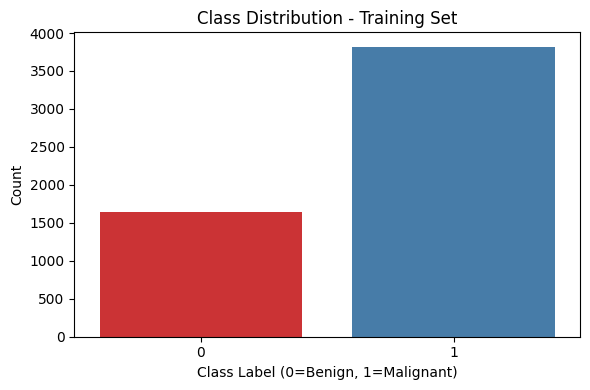


Validation Set:
Benign (0): 576 samples
Malignant (1): 1062 samples
Ratio: 1.84:1


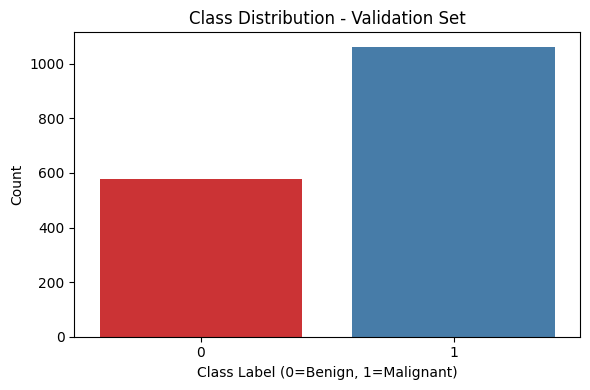


Test Set:
Benign (0): 264 samples
Malignant (1): 549 samples
Ratio: 2.08:1


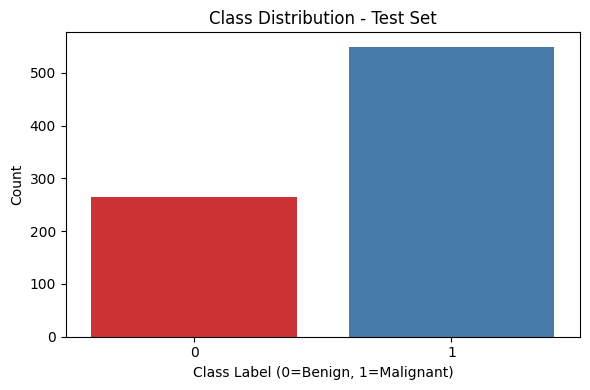

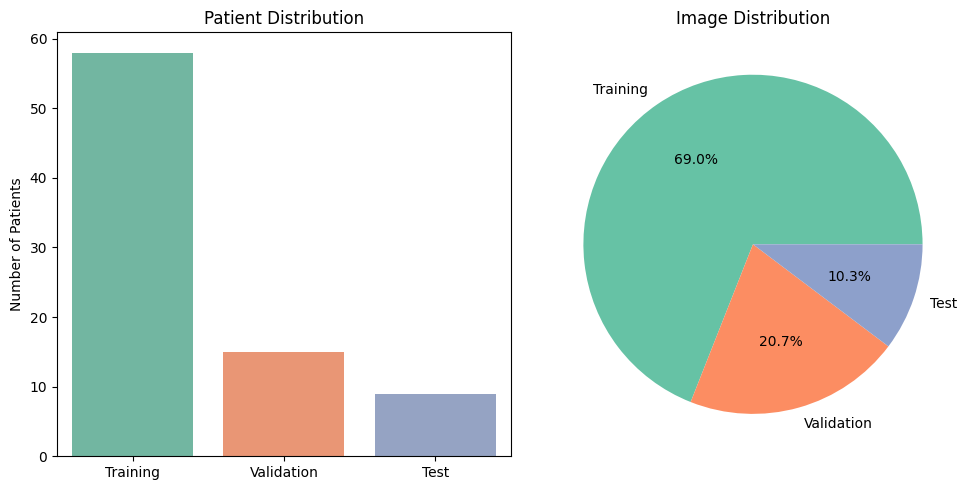


Data successfully saved:
- Training: 5458 images
- Validation: 1638 images
- Test: 813 images

=== Split Summary ===
Total patients: 82
Training patients: 58 (5458 images)
Validation patients: 15 (1638 images)
Test patients: 9 (813 images)


In [5]:
# Step 3: Robust Patient-Level Split for Medical Imaging

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Configuration
IMG_SIZE = 256
SEED = 42
MIN_VALIDATION_PATIENTS = 15  # Minimum patients for reliable validation
TEST_SIZE = 0.1  # 10% for test
VAL_SIZE = 0.15   # 15% for validation (will adjust if needed)

def patient_level_split(df, img_size=IMG_SIZE, seed=SEED):
    """Robust patient-level split with guaranteed minimum validation samples"""
    
    # Add patient_id column
    df['patient_id'] = df['image_path'].apply(lambda x: x.split(os.sep)[-3])
    unique_patients = np.array(df['patient_id'].unique())
    
    # Get patient-level labels for stratification
    patient_labels = df.groupby('patient_id')['label'].first().loc[unique_patients]
    
    # Initial stratified split (train+val vs test)
    trainval_pids, test_pids = train_test_split(
        unique_patients,
        test_size=TEST_SIZE,
        random_state=seed,
        stratify=patient_labels
    )
    
    # Secondary split with dynamic adjustment
    if len(trainval_pids) * VAL_SIZE < MIN_VALIDATION_PATIENTS:
        actual_val_ratio = max(MIN_VALIDATION_PATIENTS/len(trainval_pids), 0.15)
        train_pids, val_pids = train_test_split(
            trainval_pids,
            test_size=actual_val_ratio,
            random_state=seed,
            stratify=patient_labels[patient_labels.index.isin(trainval_pids)]
        )
    else:
        train_pids, val_pids = train_test_split(
            trainval_pids,
            test_size=VAL_SIZE,
            random_state=seed,
            stratify=patient_labels[patient_labels.index.isin(trainval_pids)]
        )
    
    # Create dataframes
    train_df = df[df['patient_id'].isin(train_pids)].reset_index(drop=True)
    val_df = df[df['patient_id'].isin(val_pids)].reset_index(drop=True)
    test_df = df[df['patient_id'].isin(test_pids)].reset_index(drop=True)
    
    return train_df, val_df, test_df, train_pids, val_pids, test_pids

# Perform the split
train_df, val_df, test_df, train_pids, val_pids, test_pids = patient_level_split(df)

# Class distribution analysis
def analyze_class_distribution(*dfs):
    """Print and visualize class distributions"""
    print("\n=== Class Distribution Analysis ===")
    for df, name in zip(dfs, ['Training', 'Validation', 'Test']):
        counts = df['label'].value_counts()
        print(f"\n{name} Set:")
        print(f"Benign (0): {counts.get(0, 0)} samples")
        print(f"Malignant (1): {counts.get(1, 0)} samples")
        print(f"Ratio: {counts.get(1, 0)/counts.get(0, 0):.2f}:1")
        
        plt.figure(figsize=(6, 4))
        sns.countplot(x='label', data=df, palette='Set1')
        plt.title(f"Class Distribution - {name} Set")
        plt.xlabel("Class Label (0=Benign, 1=Malignant)")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

analyze_class_distribution(train_df, val_df, test_df)

# Patient distribution visualization
def plot_patient_distribution(train_pids, val_pids, test_pids):
    """Visualize patient distribution across splits"""
    plt.figure(figsize=(10, 5))
    splits = ['Training', 'Validation', 'Test']
    counts = [len(train_pids), len(val_pids), len(test_pids)]
    
    plt.subplot(1, 2, 1)
    sns.barplot(x=splits, y=counts, palette="Set2")
    plt.title("Patient Distribution")
    plt.ylabel("Number of Patients")
    
    plt.subplot(1, 2, 2)
    sizes = [len(train_df), len(val_df), len(test_df)]
    plt.pie(sizes, labels=splits, autopct='%1.1f%%', colors=sns.color_palette("Set2"))
    plt.title("Image Distribution")
    
    plt.tight_layout()
    plt.show()

plot_patient_distribution(train_pids, val_pids, test_pids)

# Data loading and saving (unchanged)
def load_and_save_data(train_df, val_df, test_df, img_size=IMG_SIZE):
    """Load and save image data with medical preprocessing"""
    def load_images(df):
        images = [preprocess_input(image.img_to_array(
            image.load_img(path, target_size=(img_size, img_size))))
            for path in df['image_path']]
        return np.array(images), np.array(df['label'])
    
    X_train, y_train = load_images(train_df)
    X_val, y_val = load_images(val_df)
    X_test, y_test = load_images(test_df)
    
    np.save("X_train.npy", X_train)
    np.save("y_train_main.npy", y_train)
    np.save("X_val.npy", X_val)
    np.save("y_val_main.npy", y_val)
    np.save("X_test.npy", X_test)
    np.save("y_test_main.npy", y_test)
    
    print("\nData successfully saved:")
    print(f"- Training: {len(X_train)} images")
    print(f"- Validation: {len(X_val)} images")
    print(f"- Test: {len(X_test)} images")

load_and_save_data(train_df, val_df, test_df)

print("\n=== Split Summary ===")
print(f"Total patients: {len(train_pids)+len(val_pids)+len(test_pids)}")
print(f"Training patients: {len(train_pids)} ({len(train_df)} images)")
print(f"Validation patients: {len(val_pids)} ({len(val_df)} images)")
print(f"Test patients: {len(test_pids)} ({len(test_df)} images)")


=== Applying Medical-Optimized Class Balancing ===

=== Medical Class Balancing ===
Original Distribution - Class 0: 1640, Class 1: 3818
Minority Class: 0 (will be augmented)

Using Patient-Aware Oversampling (Medical Best Practice)

Balanced Distribution:
Class 0: 3818, Class 1: 3818
Patients after balancing: 58

Quality Check Passed: Patient distribution maintained


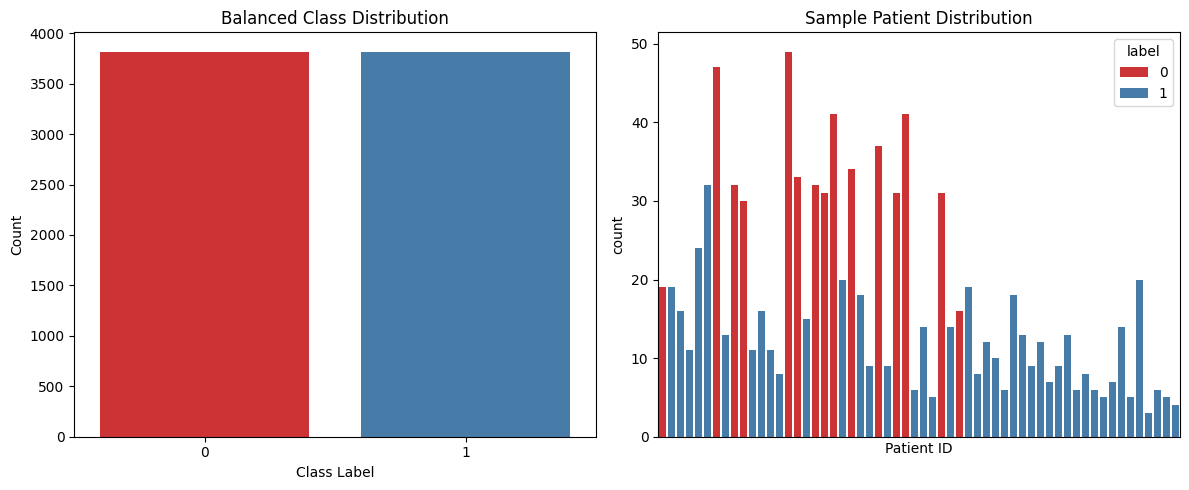

In [6]:
# Step 3B: Medical-Optimized Class Balancing

def balance_medical_classes(train_df, strategy='oversample', seed=SEED, patient_aware=True):
    """
    Enhanced class balancing for medical imaging with patient-aware options
    
    Args:
        train_df: DataFrame with 'label', 'patient_id', and 'image_path' columns
        strategy: 'oversample', 'smote', or 'patient_aware_oversample'
        seed: Random seed for reproducibility
        patient_aware: Maintain patient distribution when oversampling (medical best practice)
        
    Returns:
        Balanced DataFrame with preserved medical metadata
    """
    # Verify input columns
    assert all(col in train_df.columns for col in ['label', 'patient_id', 'image_path'])
    
    # Analyze initial distribution
    class_counts = train_df['label'].value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()
    
    print("\n=== Medical Class Balancing ===")
    print(f"Original Distribution - Class 0: {class_counts.get(0, 0)}, Class 1: {class_counts.get(1, 0)}")
    print(f"Minority Class: {minority_class} (will be augmented)")
    
    if strategy == 'patient_aware_oversample':
        print("\nUsing Patient-Aware Oversampling (Medical Best Practice)")
        
        # Group by patient to maintain patient distribution
        patient_groups = train_df.groupby(['patient_id', 'label'])
        samples_needed = class_counts[majority_class] - class_counts[minority_class]
        
        # Collect augmented samples
        augmented_samples = []
        while len(augmented_samples) < samples_needed:
            for (pid, label), group in patient_groups:
                if label == minority_class:
                    augmented_samples.append(group.sample(1, random_state=seed+len(augmented_samples)))
            if not augmented_samples:  # Handle case with no minority samples
                raise ValueError("No minority class samples found in training set")
        
        balanced_df = pd.concat([
            train_df,
            pd.concat(augmented_samples[:samples_needed])
        ]).sample(frac=1, random_state=seed).reset_index(drop=True)
        
    elif strategy == 'oversample':
        print("\nUsing Standard Oversampling")
        minority_df = train_df[train_df['label'] == minority_class]
        oversampled = minority_df.sample(
            class_counts[majority_class],
            replace=True,
            random_state=seed
        )
        balanced_df = pd.concat([
            train_df[train_df['label'] == majority_class],
            oversampled
        ]).sample(frac=1, random_state=seed).reset_index(drop=True)
        
    elif strategy == 'smote':
        try:
            from imblearn.over_sampling import SMOTE
            print("\nUsing SMOTE with Medical Metadata Preservation")
            
            # Temporary numeric features for SMOTE
            X = train_df[['patient_id']].copy()
            X['dummy'] = 1  # SMOTE requires numeric features
            y = train_df['label']
            
            sm = SMOTE(random_state=seed)
            X_res, y_res = sm.fit_resample(X, y)
            
            # Reconstruct DataFrame while preserving original images
            balanced_df = train_df.copy()
            added_samples = len(y_res) - len(y)
            minority_samples = train_df[train_df['label'] == minority_class]
            
            # Add sampled minority cases to match SMOTE output count
            balanced_df = pd.concat([
                balanced_df,
                minority_samples.sample(added_samples, replace=True, random_state=seed)
            ]).sample(frac=1, random_state=seed).reset_index(drop=True)
            
        except ImportError:
            print("SMOTE not available, falling back to patient-aware oversampling")
            return balance_medical_classes(train_df, strategy='patient_aware_oversample', seed=seed)
    
    else:
        raise ValueError(f"Unknown strategy: {strategy}. Choose 'oversample', 'smote', or 'patient_aware_oversample'")

    # Verify results
    new_counts = balanced_df['label'].value_counts()
    print("\nBalanced Distribution:")
    print(f"Class 0: {new_counts.get(0, 0)}, Class 1: {new_counts.get(1, 0)}")
    print(f"Patients after balancing: {balanced_df['patient_id'].nunique()}")
    
    return balanced_df

# Apply with medical best practices
print("\n=== Applying Medical-Optimized Class Balancing ===")
train_df = balance_medical_classes(
    train_df,
    strategy='patient_aware_oversample',  # Recommended for medical imaging
    seed=SEED
)

# Quality check
assert train_df['patient_id'].nunique() == len(train_pids), "Patient count changed during balancing!"
print("\nQuality Check Passed: Patient distribution maintained")

# Visual verification
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='label', data=train_df, palette='Set1')
plt.title('Balanced Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='patient_id', hue='label', data=train_df.sample(1000, random_state=SEED), 
              palette='Set1', dodge=False)
plt.title('Sample Patient Distribution')
plt.xlabel('Patient ID')
plt.xticks([])
plt.tight_layout()
plt.show()

In [7]:
# Step 4: Data Generators, Augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = 256
BATCH_SIZE = 32

# Convert numeric label to string class name
label_map = {0: 'benign', 1: 'malignant'}
train_df['label'] = train_df['label'].map(label_map).astype(str)
val_df['label'] = val_df['label'].map(label_map).astype(str)

# Print individual class counts
for label in train_df['label'].unique():
    count = train_df[train_df['label'] == label].shape[0]
    print(f"Found {count} validated image filenames belonging to class: ['{label}']")

for label in val_df['label'].unique():
    count = val_df[val_df['label'] == label].shape[0]
    print(f"Found {count} validated image filenames belonging to class: ['{label}']")

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=SEED
)
print("Data generators created successfully.")


Found 3818 validated image filenames belonging to class: ['benign']
Found 3818 validated image filenames belonging to class: ['malignant']
Found 576 validated image filenames belonging to class: ['benign']
Found 1062 validated image filenames belonging to class: ['malignant']
Found 7636 validated image filenames belonging to 2 classes.
Found 1638 validated image filenames belonging to 2 classes.
Data generators created successfully.


In [8]:
# Step 5: Stratified K-Fold Cross-Validation (Patient-Level)
from collections import defaultdict

N_FOLDS = 5
metadata_df = df.copy()
metadata_df['main_label'] = metadata_df['label']

patient_df = metadata_df.groupby('patient_id').agg({
    'main_label': 'first'
}).reset_index()

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
folds = defaultdict(dict)

for fold, (train_idx, val_idx) in enumerate(skf.split(patient_df['patient_id'], patient_df['main_label'])):
    train_pids = patient_df.iloc[train_idx]['patient_id'].values
    val_pids = patient_df.iloc[val_idx]['patient_id'].values

    folds[fold]['train'] = metadata_df[metadata_df['patient_id'].isin(train_pids)].reset_index(drop=True)
    folds[fold]['val'] = metadata_df[metadata_df['patient_id'].isin(val_pids)].reset_index(drop=True)

    print(f"Fold {fold + 1}: Train={len(train_pids)} patients, Val={len(val_pids)} patients")

    # Optional: save to CSV
    folds[fold]['train'].to_csv(f'fold{fold}_train.csv', index=False)
    folds[fold]['val'].to_csv(f'fold{fold}_val.csv', index=False)

Fold 1: Train=65 patients, Val=17 patients
Fold 2: Train=65 patients, Val=17 patients
Fold 3: Train=66 patients, Val=16 patients
Fold 4: Train=66 patients, Val=16 patients
Fold 5: Train=66 patients, Val=16 patients



Approximate Class Weights (Train Set):
  Class 1 (Malignant): Weight = 1.4712
  Class 0 (Benign): Weight = 3.1222

Visualizing class and patient distributions...


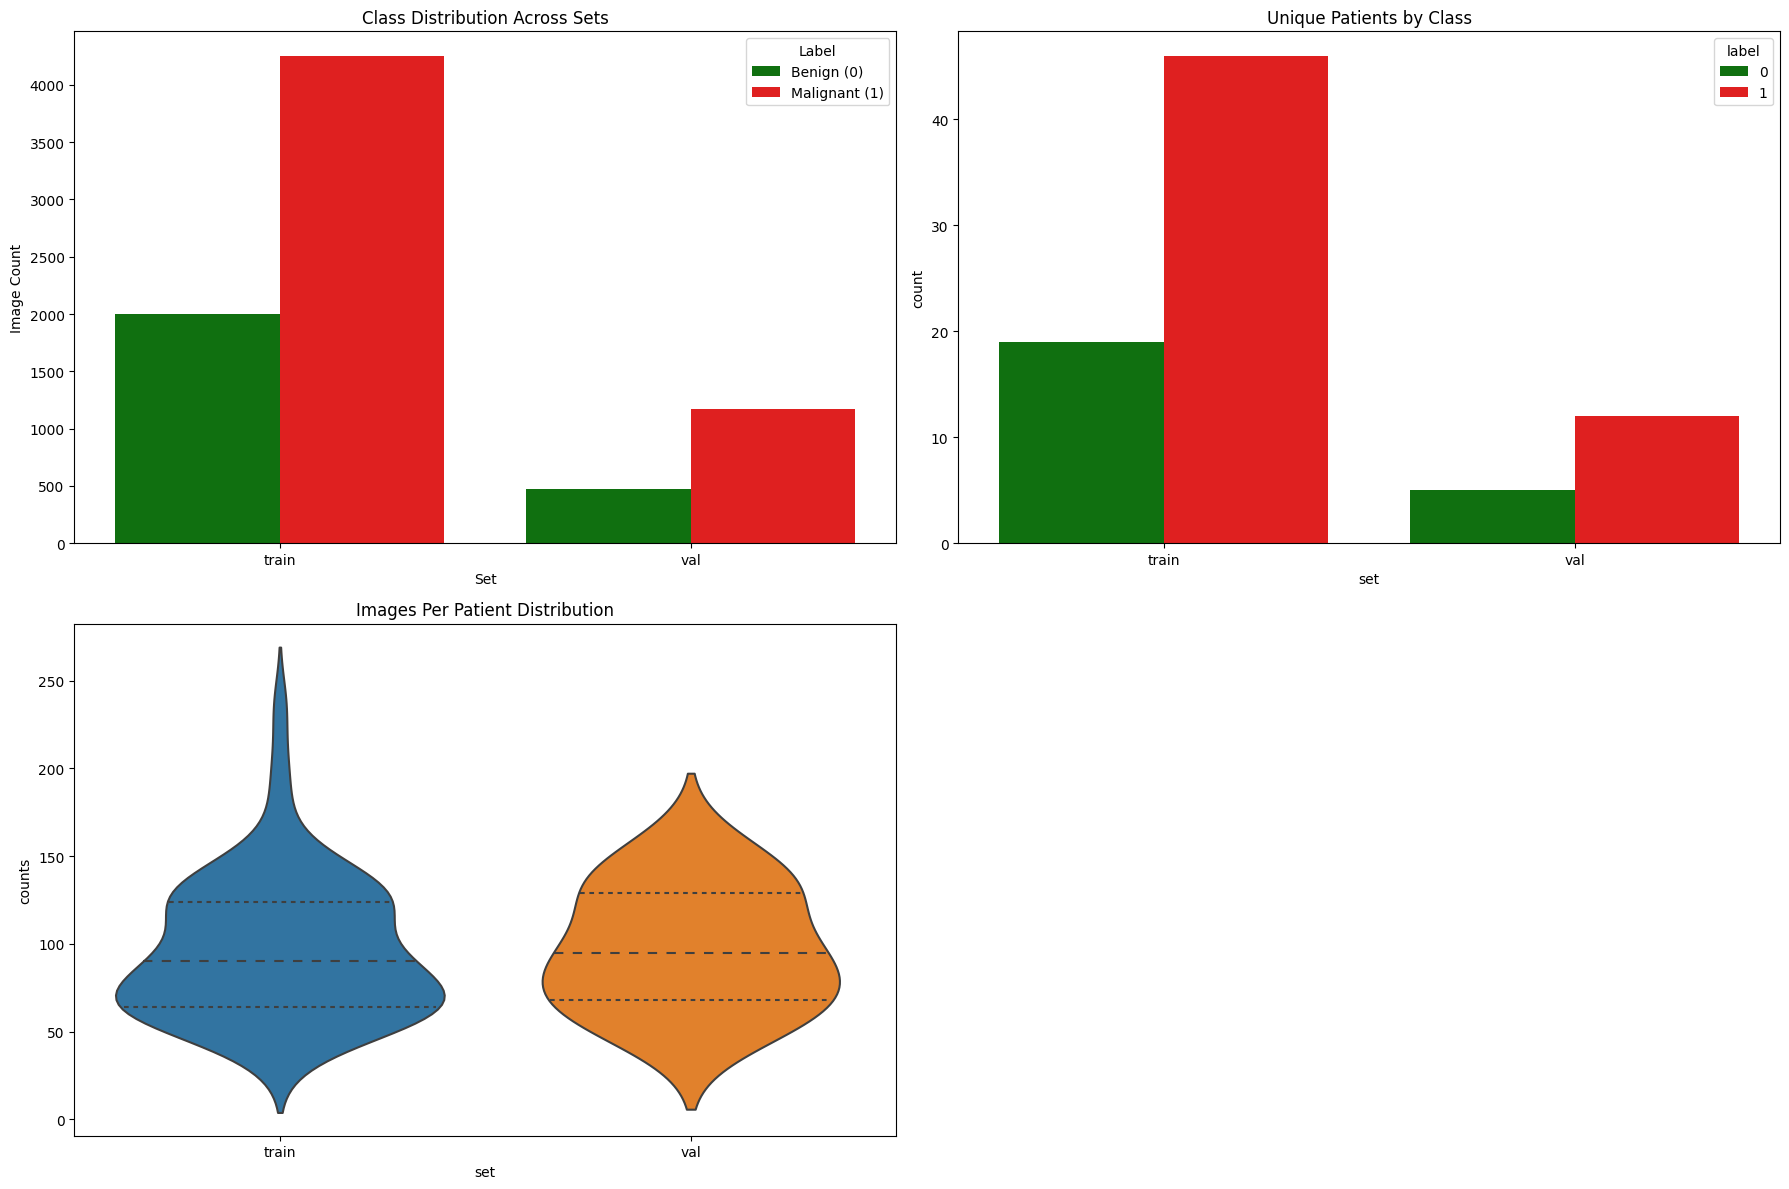


Summary Statistics:
Patient Distribution per Set:
label   0   1
set          
train  19  46
val     5  12

Image Count per Patient (per set):
       count       mean        std   min   25%   50%    75%    max
set                                                               
train   65.0  96.307692  39.261512  38.0  64.0  90.0  124.0  235.0
val     17.0  97.000000  34.556114  45.0  68.0  95.0  129.0  158.0

Patient overlap between sets: None

Minimum images per patient per set:
set
train    38
val      45
dtype: int64

Metadata saved to patient_splits.csv


In [9]:
# Step 5C: Visualization & Metadata Saving (Binary Only)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

#Plot Function
def visualize_binary_class_distributions(data_df):
    plt.figure(figsize=(18, 12))

    # Plot 1: Class Distribution Across Sets
    plt.subplot(2, 2, 1)
    sns.countplot(data=data_df, x='set', hue='label', palette={0: 'green', 1: 'red'})
    plt.title('Class Distribution Across Sets')
    plt.xlabel('Set')
    plt.ylabel('Image Count')
    plt.legend(title='Label', labels=['Benign (0)', 'Malignant (1)'])

    # Plot 2: Unique Patients by Class
    plt.subplot(2, 2, 2)
    patient_stats = data_df.groupby(['patient_id', 'set']).agg({'label': 'first'}).reset_index()
    sns.countplot(data=patient_stats, x='set', hue='label', palette={0: 'green', 1: 'red'})
    plt.title('Unique Patients by Class')

    # Plot 3: Image Count per Patient (Violin Plot)
    plt.subplot(2, 2, 3)
    img_counts = data_df.groupby(['set', 'patient_id']).size().reset_index(name='counts')
    sns.violinplot(data=img_counts, x='set', y='counts', inner='quartile')
    plt.title('Images Per Patient Distribution')

    plt.tight_layout()
    plt.savefig('data_distribution.png', dpi=300)
    plt.show()

#Main Execution
try:
    # Assumes your df has: image_path, label, patient_id
    unique_patients = df['patient_id'].unique()
    train_pats, val_pats = train_test_split(
        unique_patients,
        test_size=0.2,
        random_state=42,
        stratify=df.groupby('patient_id')['label'].first()
    )

    df['set'] = np.select(
        [
            df['patient_id'].isin(train_pats),
            df['patient_id'].isin(val_pats)
        ],
        ['train', 'val'],
        default='unassigned'
    )

    # Print class balance
    label_counts = df[df['set'] == 'train']['label'].value_counts(normalize=True)
    print("\nApproximate Class Weights (Train Set):")
    for cls, freq in label_counts.items():
        print(f"  Class {cls} ({'Benign' if cls == 0 else 'Malignant'}): Weight = {1 / freq:.4f}")

    # Visualize
    print("\nVisualizing class and patient distributions...")
    visualize_binary_class_distributions(df)

    # Summary stats
    print("\nSummary Statistics:")
    print("Patient Distribution per Set:")
    print(df.drop_duplicates(['patient_id', 'label']).groupby(['set', 'label']).size().unstack(fill_value=0))

    print("\nImage Count per Patient (per set):")
    print(df.groupby(['set', 'patient_id']).size().groupby('set').describe())

    # Overlap check
    overlap = set(train_pats) & set(val_pats)
    print(f"\nPatient overlap between sets: {'Yes' if overlap else 'None'}")

    print("\nMinimum images per patient per set:")
    print(df.groupby(['set', 'patient_id']).size().groupby('set').min())

    # Save metadata
    df.to_csv('patient_splits.csv', index=False)
    print("\nMetadata saved to patient_splits.csv")

except Exception as e:
    print(f"\nERROR during metadata visualization/saving: {e}")


In [10]:
# Step 6: ResNet50 Functional Model for Binary Classification
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

#Configuration
IMG_HEIGHT = 256
IMG_WIDTH = 256
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
NUM_CLASSES = 1  
LEARNING_RATE = 1e-4

def build_resnet50_binary_classifier(input_shape=INPUT_SHAPE, freeze_ratio=0.6, learning_rate=LEARNING_RATE):
    # Input
    inputs = Input(shape=input_shape, name="input_image")

    # Base ResNet50 model
    resnet_base = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs, pooling='avg')

    # Freeze first 60% of layers
    num_layers_to_freeze = int(freeze_ratio * len(resnet_base.layers))
    for i, layer in enumerate(resnet_base.layers):
        layer.trainable = False if i < num_layers_to_freeze else True

    # Custom head 
    x = resnet_base.output
    x = layers.Flatten(name="flatten")(x)

    x = layers.Dense(256, name="dense_256")(x)
    x = layers.BatchNormalization(name="bn_256")(x)
    x = layers.Activation('relu', name="act_256")(x)

    x = layers.Dense(128, name="dense_128")(x)
    x = layers.BatchNormalization(name="bn_128")(x)
    x = layers.Activation('relu', name="act_128")(x)

    x = layers.Dense(64, name="dense_64")(x)
    x = layers.BatchNormalization(name="bn_64")(x)
    x = layers.Activation('relu', name="act_64")(x)

    x = layers.Dropout(0.4, name="dropout")(x)

    output = layers.Dense(1, activation='sigmoid', name="output")(x)

    # Model definition
    model = models.Model(inputs=inputs, outputs=output, name="ResNet50_Binary_Classifier")

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )

    return model

#Build and summarize
model = build_resnet50_binary_classifier()
model.summary()


I0000 00:00:1753273055.525466    1601 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753273055.526262    1601 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ResNet50_Binary_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_image[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 24,155,265 (92.15 MB)

 Trainable params: 19,754,625 (75.36 MB)

 Non-trainable params: 4,400,640 (16.79 MB)

In [11]:
#Step 7: Training Model with K-Fold Cross-Validation

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.regularizers import l2 

# Configuration
IMG_SIZE = (256, 256)
EPOCHS = 10  
BATCH_SIZE = 32
LEARNING_RATE = 4e-4
N_FOLDS = 5

# Load all data
X = np.load('X_train.npy')  # Contains all training data
y = np.load('y_train_main.npy')  # Contains all labels

# Initialize KFold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Store fold results
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n{'='*40}")
    print(f"Training Fold {fold + 1}/{N_FOLDS}")
    print(f"{'='*40}")
    
    # Split data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Compute Binary Class Weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: float(w) for i, w in enumerate(class_weights)}

    print("Approximate Class Weights (Train Set):")
    for cls, weight in class_weight_dict.items():
        print(f"  Class {cls}: Weight = {weight:.4f}")

    # Build Model (fresh model for each fold)
    def build_resnet50_binary_classifier(learning_rate=1e-4):
        from tensorflow.keras.applications import ResNet50
        from tensorflow.keras.models import Model
        from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
        from tensorflow.keras.regularizers import l2

        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
        output = Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-4))(x) 

        model = Model(inputs=base_model.input, outputs=output)
        return model

    model = build_resnet50_binary_classifier(learning_rate=LEARNING_RATE)

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6, verbose=1),
        ModelCheckpoint(f'best_model_fold{fold}.keras', save_best_only=True, monitor='val_loss', verbose=1)
    ]

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    
    # Store fold results
    fold_results.append({
        'history': history.history,
        'val_metrics': model.evaluate(X_val, y_val, verbose=0)
    })

print("\nK-Fold Cross-Validation completed successfully.")

# analyze fold_results for performance across all folds
final_val_metrics = np.mean([res['val_metrics'] for res in fold_results], axis=0)
print("\nAverage Validation Metrics Across All Folds:")
print(f"Loss: {final_val_metrics[0]:.4f}")
print(f"Accuracy: {final_val_metrics[1]:.4f}")
print(f"AUC: {final_val_metrics[2]:.4f}")
print(f"Precision: {final_val_metrics[3]:.4f}")
print(f"Recall: {final_val_metrics[4]:.4f}")


Training Fold 1/5
Approximate Class Weights (Train Set):
  Class 0: Weight = 1.6639
  Class 1: Weight = 0.7148
Epoch 1/10


I0000 00:00:1753273122.602519    1657 service.cc:148] XLA service 0x7b2358002970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753273122.604106    1657 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753273122.604136    1657 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753273127.509187    1657 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753273151.954728    1657 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8356 - auc: 0.9055 - loss: 0.4531 - precision: 0.9213 - recall: 0.8360
Epoch 1: val_loss improved from inf to 9.62003, saving model to best_model_fold0.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 164s 617ms/step - accuracy: 0.8359 - auc: 0.9058 - loss: 0.4524 - precision: 0.9215 - recall: 0.8363 - val_accuracy: 0.7747 - val_auc: 0.6671 - val_loss: 9.6200 - val_precision: 0.7627 - val_recall: 0.9843 - learning_rate: 4.0000e-04
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9218 - auc: 0.9785 - loss: 0.2299 - precision: 0.9705 - recall: 0.9151
Epoch 2: val_loss improved from 9.62003 to 3.74620, saving model to best_model_fold0.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 54s 393ms/step - accuracy: 0.9218 - auc: 0.9785 - loss: 0.2300 - precision: 0.9705 - recall: 0.9151 - val_accuracy: 0.8159 - val_auc: 0.7425 - val_loss: 3.7462 - val_precision: 0.8024 - val_recall: 0.9777 - learning_rate: 4.0000e-04
Epoch 3/10
137/137 ━━━━━━━━━━━

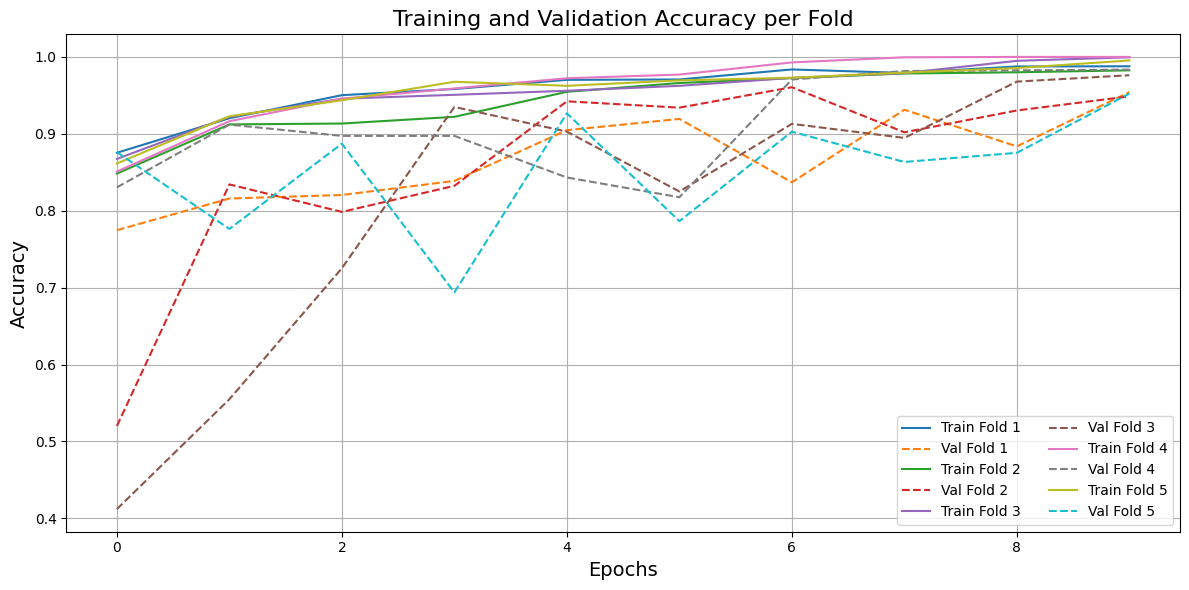

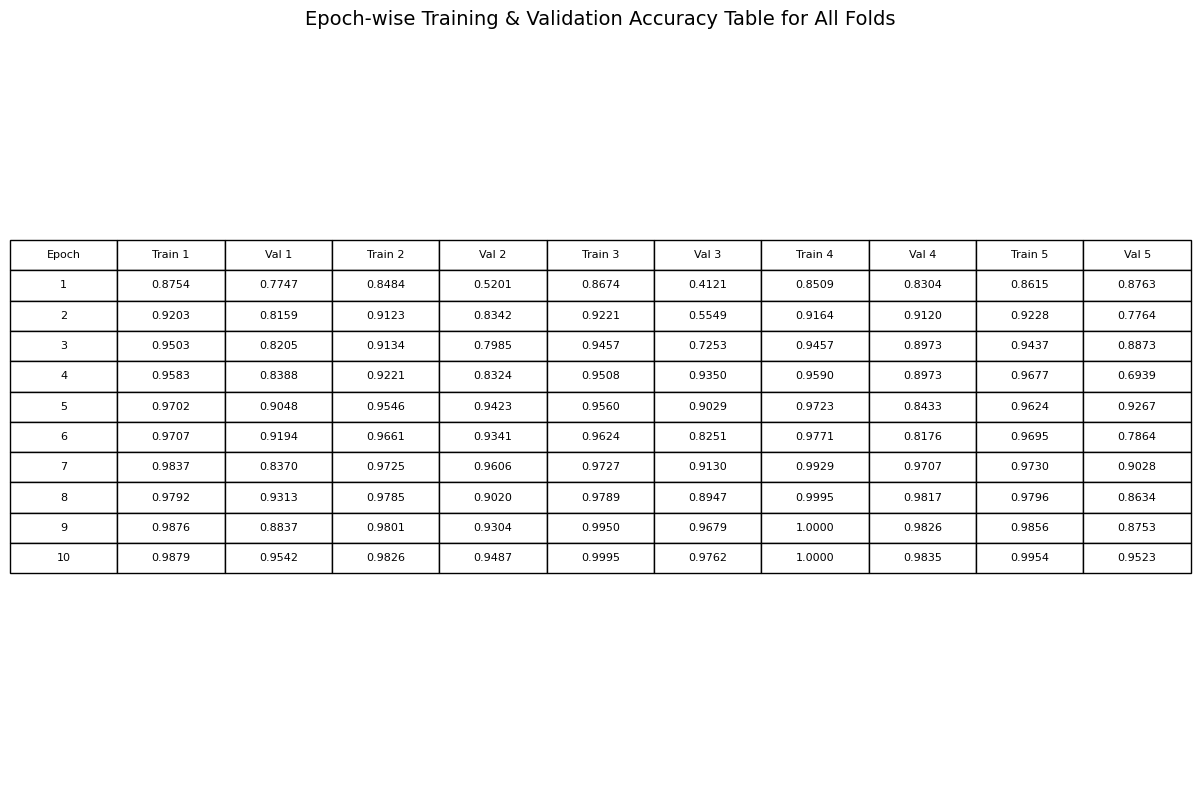

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training & validation accuracy for each fold
plt.figure(figsize=(12, 6))
table_data = []
max_epochs = max(len(res['history']['accuracy']) for res in fold_results)

# Header row
header = ["Epoch"]
for i in range(len(fold_results)):
    header.append(f"Train {i+1}")
    header.append(f"Val {i+1}")

# Collect data
for epoch in range(max_epochs):
    row = [epoch + 1]
    for res in fold_results:
        hist = res['history']
        if epoch < len(hist['accuracy']):
            row.append(f"{hist['accuracy'][epoch]:.4f}")
            row.append(f"{hist['val_accuracy'][epoch]:.4f}")
        else:
            row.append("-")
            row.append("-")
    table_data.append(row)

# Plot curves
for i, result in enumerate(fold_results):
    history = result['history']
    plt.plot(history['accuracy'], label=f'Train Fold {i+1}')
    plt.plot(history['val_accuracy'], linestyle='--', label=f'Val Fold {i+1}')
plt.title('Training and Validation Accuracy per Fold', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', ncol=2)
plt.grid(True)
plt.tight_layout()

# Add table
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')
tbl = ax.table(cellText=table_data,
               colLabels=header,
               cellLoc='center',
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1.2, 1.5)

plt.title('Epoch-wise Training & Validation Accuracy Table for All Folds', fontsize=14)
plt.tight_layout()
plt.show()


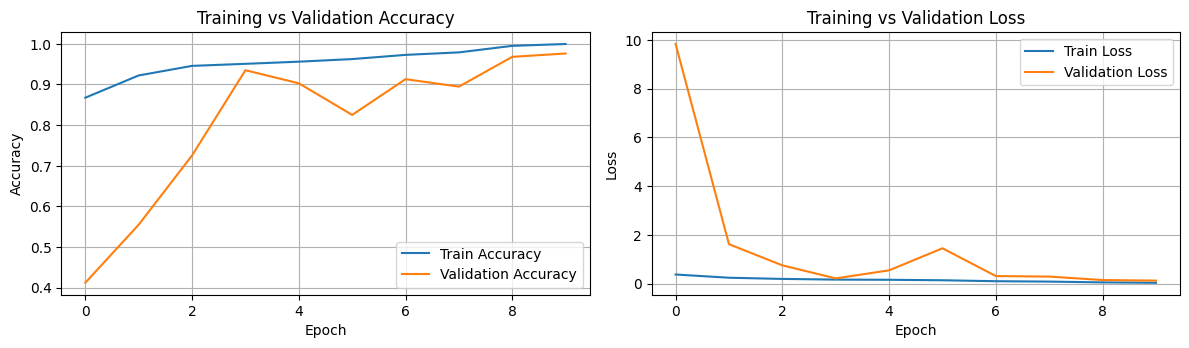

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Use last fold's history or specify another index
history = fold_results[2]['history']

# Plot Training and Validation Accuracy & Loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Prepare table data
epochs = list(range(1, len(history['accuracy']) + 1))
table_data = []
for i in range(len(epochs)):
    table_data.append([
        epochs[i],
        f"{history['accuracy'][i]:.4f}",
        f"{history['val_accuracy'][i]:.4f}",
        f"{history['loss'][i]:.4f}",
        f"{history['val_loss'][i]:.4f}"
    ])

plt.show()


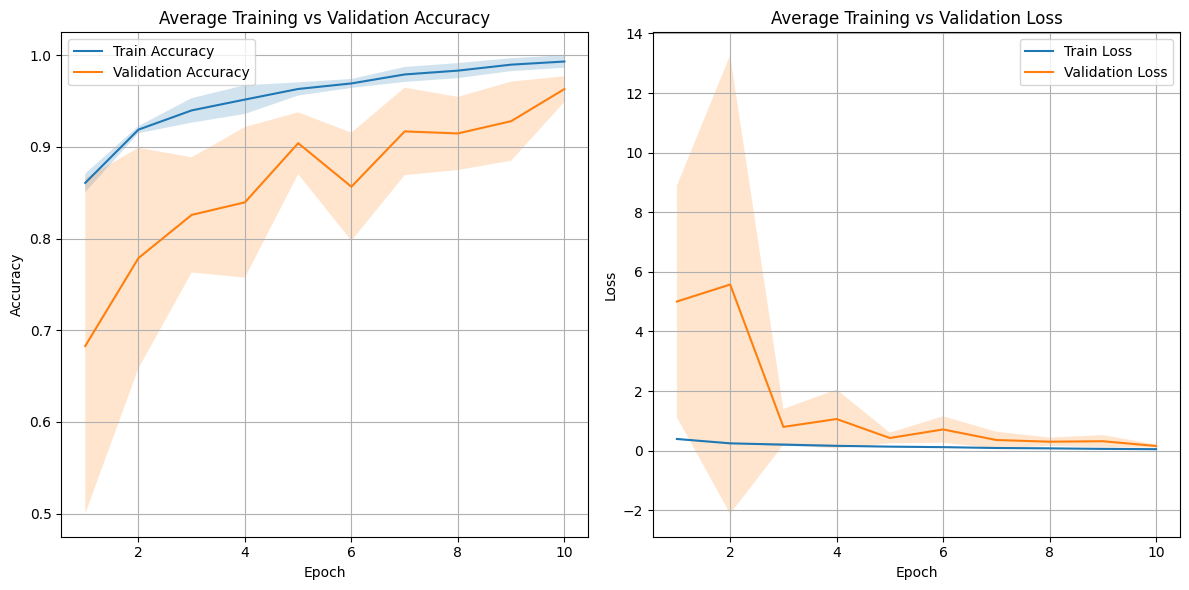

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Compute mean & std for Accuracy & Loss
metrics = ['accuracy', 'loss']
num_epochs = len(fold_results[0]['history']['accuracy'])

# Init
avg_metrics = {m: [] for m in metrics}
avg_metrics.update({f'val_{m}': [] for m in metrics})
std_metrics = {m: [] for m in metrics}
std_metrics.update({f'val_{m}': [] for m in metrics})

# Loop
for epoch in range(num_epochs):
    for m in metrics:
        train_vals = []
        val_vals = []
        for fold in fold_results:
            hist = fold['history']
            if m in hist:
                train_vals.append(hist[m][epoch])
            if f'val_{m}' in hist:
                val_vals.append(hist[f'val_{m}'][epoch])
        avg_metrics[m].append(np.mean(train_vals))
        avg_metrics[f'val_{m}'].append(np.mean(val_vals))
        std_metrics[m].append(np.std(train_vals))
        std_metrics[f'val_{m}'].append(np.std(val_vals))

# Plot
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(12, 6))

# Accuracy plot 
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_metrics['accuracy'], label='Train Accuracy')
plt.fill_between(epochs,
                 np.array(avg_metrics['accuracy']) - np.array(std_metrics['accuracy']),
                 np.array(avg_metrics['accuracy']) + np.array(std_metrics['accuracy']),
                 alpha=0.2)
plt.plot(epochs, avg_metrics['val_accuracy'], label='Validation Accuracy')
plt.fill_between(epochs,
                 np.array(avg_metrics['val_accuracy']) - np.array(std_metrics['val_accuracy']),
                 np.array(avg_metrics['val_accuracy']) + np.array(std_metrics['val_accuracy']),
                 alpha=0.2)
plt.title('Average Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot 
plt.subplot(1, 2, 2)
plt.plot(epochs, avg_metrics['loss'], label='Train Loss')
plt.fill_between(epochs,
                 np.array(avg_metrics['loss']) - np.array(std_metrics['loss']),
                 np.array(avg_metrics['loss']) + np.array(std_metrics['loss']),
                 alpha=0.2)
plt.plot(epochs, avg_metrics['val_loss'], label='Validation Loss')
plt.fill_between(epochs,
                 np.array(avg_metrics['val_loss']) - np.array(std_metrics['val_loss']),
                 np.array(avg_metrics['val_loss']) + np.array(std_metrics['val_loss']),
                 alpha=0.2)
plt.title('Average Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()


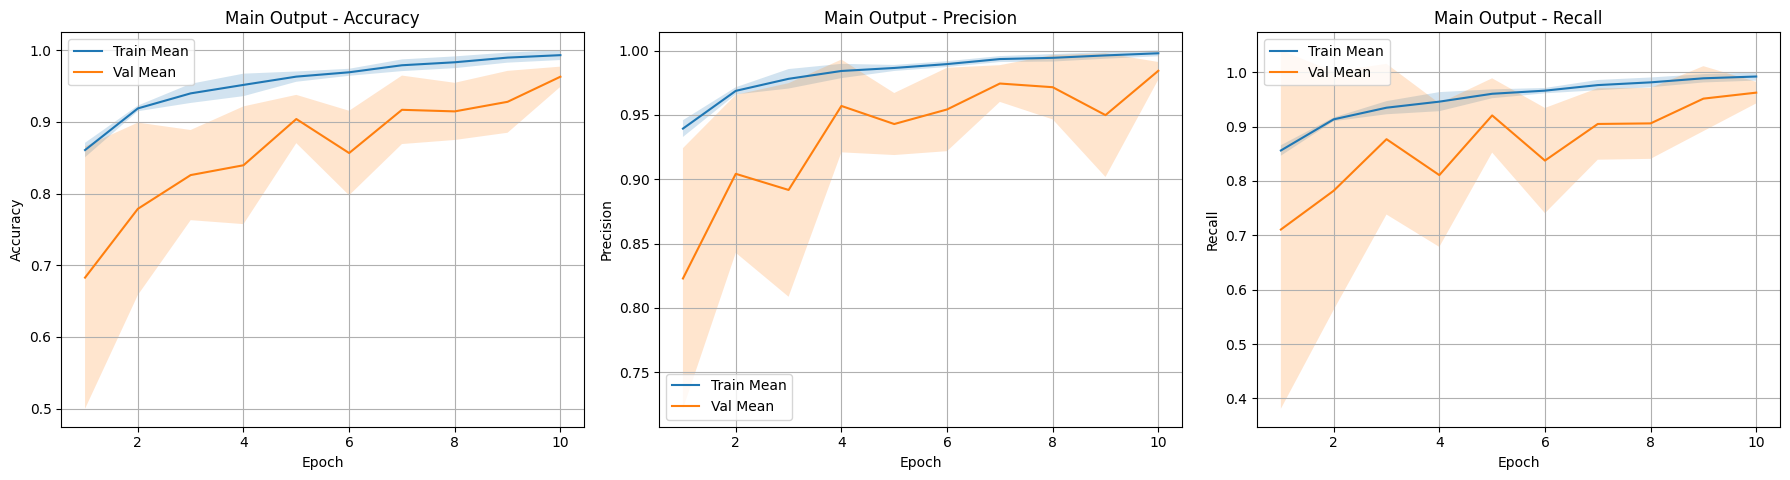

In [33]:
# Step 10A: Combined accuracy, precision and recall
import numpy as np
import matplotlib.pyplot as plt

metrics = ['accuracy', 'precision', 'recall']
num_epochs = len(fold_results[0]['history']['accuracy'])
num_folds = len(fold_results)

# Dicts to store mean & std for each metric
avg_metrics = {m: [] for m in metrics}
avg_metrics.update({f'val_{m}': [] for m in metrics})
std_metrics = {m: [] for m in metrics}
std_metrics.update({f'val_{m}': [] for m in metrics})

# Compute mean and std
for epoch in range(num_epochs):
    for m in metrics:
        train_vals = []
        val_vals = []
        for fold in fold_results:
            hist = fold['history']  # This works for your structure
            if m in hist:
                train_vals.append(hist[m][epoch])
            if f'val_{m}' in hist:
                val_vals.append(hist[f'val_{m}'][epoch])
        avg_metrics[m].append(np.mean(train_vals))
        avg_metrics[f'val_{m}'].append(np.mean(val_vals))
        std_metrics[m].append(np.std(train_vals))
        std_metrics[f'val_{m}'].append(np.std(val_vals))

# DummyHistory for compatibility
class DummyHistory:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

mean_std_history = DummyHistory(avg_metrics, std_metrics)

# Plot with std shading
def plot_main_output_metrics_with_std(mean_std_history):
    metrics = ['accuracy', 'precision', 'recall']
    plt.figure(figsize=(18, 7))
    epochs = list(range(1, num_epochs + 1))

    for i, metric in enumerate(metrics):
        train_key = metric
        val_key = f'val_{metric}'

        plt.subplot(1, 3, i + 1)
        if train_key in mean_std_history.mean:
            # Mean and std
            train_mean = mean_std_history.mean[train_key]
            val_mean = mean_std_history.mean[val_key]
            train_std = mean_std_history.std[train_key]
            val_std = mean_std_history.std[val_key]

            plt.plot(epochs, train_mean, label='Train Mean')
            plt.fill_between(epochs,
                             np.array(train_mean) - np.array(train_std),
                             np.array(train_mean) + np.array(train_std),
                             alpha=0.2)

            plt.plot(epochs, val_mean, label='Val Mean')
            plt.fill_between(epochs,
                             np.array(val_mean) - np.array(val_std),
                             np.array(val_mean) + np.array(val_std),
                             alpha=0.2)

            plt.title(f'Main Output - {metric.capitalize()}')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.grid(True)
            plt.legend()
        else:
            plt.text(0.5, 0.5, f'No data for {metric}', ha='center', va='center')
            plt.axis('off')

    plt.tight_layout(rect=[0, 0.3, 1, 1])

    plt.show()

plot_main_output_metrics_with_std(mean_std_history)



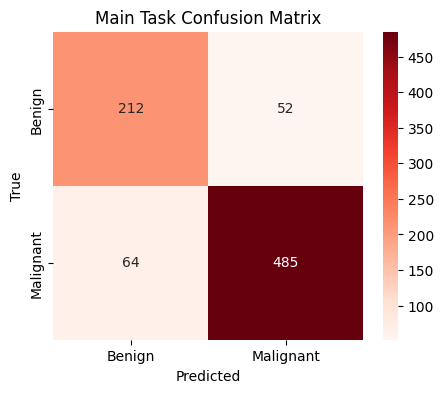

In [37]:
#Step 10B: Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load true test labels
X_test = np.load("X_test.npy")
y_test_main = np.load("y_test_main.npy")

# Predict probabilities for main output only
y_pred_main_probs = model.predict(X_test, verbose=0)

# Convert predicted probabilities to class labels
if y_pred_main_probs.shape[1] == 1:
    y_pred_main = (y_pred_main_probs > 0.5).astype(int).flatten()
else:
    y_pred_main = np.argmax(y_pred_main_probs, axis=1)

# Plot confusion matrix helper
def plot_cm(cm, labels, title, cmap, filename):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename, dpi=300)
    plt.show()

# Main task confusion matrix
main_labels = ['Benign', 'Malignant']
cm_main = confusion_matrix(y_test_main, y_pred_main)
plot_cm(cm_main, main_labels, 'Main Task Confusion Matrix', 'Reds', 'main_confusion_matrix.png')


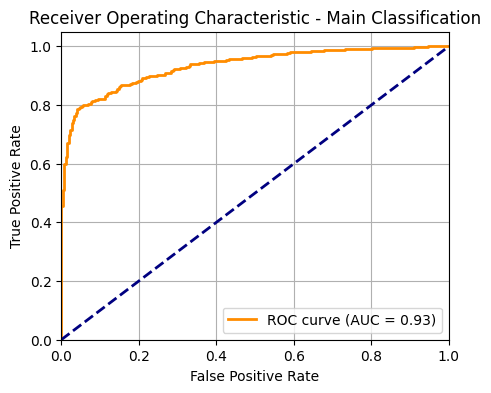

In [38]:
# Step 10C: AUC & ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Load true test labels
X_test = np.load("X_test.npy")
y_test_main = np.load("y_test_main.npy")

# Predict probabilities for main output only
y_pred_main_probs = model.predict(X_test, verbose=0)

# Binary classification AUC-ROC
if y_pred_main_probs.shape[1] == 1 or len(y_pred_main_probs.shape) == 1:
    y_score = y_pred_main_probs.flatten()
    
    # Ensure y_test_main is also flattened and integer type
    y_test_main = y_test_main.flatten().astype(int)

    fpr, tpr, _ = roc_curve(y_test_main, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Main Classification')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig('main_output_roc_curve.png', dpi=300)
    plt.show()

else:
    print("ROC curve is only applicable for binary classification. Skipping plot.")
